In [1]:
# If running from Colab, please uncomment and run the following cell to get summer installed.
# !pip install summerepi2==1.3.3

In [2]:
import pandas as pd
from jax import numpy as jnp
from datetime import datetime
from summer2 import CompartmentalModel, StrainStratification
from summer2.parameters import Parameter, DerivedOutput, Function, Time
from plotly import graph_objects as go
pd.options.plotting.backend = 'plotly'

## Multiple competing strains
This notebook applies a two-strain stratification to the base model.
The two strains compete for the same susceptible population.
The assumption that recovered persons are immune to futher infection
has not been adjusted.

### Seeding
So that the two strains are seeded in the same way,
we first ensure that all of the starting population is susceptible.
We then use a triangular function to injected infectious
persons into the model in order to seed the epidemic with each strain.
The time that each strain is introduced is then parameterised for
each strain that is introduced.
The duration and rate of the seed is relatively unimportant
because most of the dynamics are driven by transmission 
as soon as the prevalence of the new strain reaches substantial levels.

### Competition
Because the assumption of complete immunity after infection has not beeen relaxed,
this implies that after recovery,
people are fully immune to infection with either strain.
Given that we introduce the second (`mutant`) strain some time
after the introduction of the first (`wild`) strain
when the epidemic has begun to decline,
there are relatively few susceptibles for the second strain to infect.
We therefore increase its infectiousness to very high levels to get
an observable epidemic.
This is unlikely to be the best way to model most competing strain dynamics, 
but illustrates the code structure for implementing multi-strain models.
In practice, and for simulating COVID-19 dynamics,
we would likely wish to allow for subsequent strains to escape 
past immunity.
To achieve this, we would have to implement reinfection processes in the model.

In [3]:
iso = 'MYS'

In [4]:
cases_data = pd.read_csv('https://github.com/monash-emu/wpro_working/raw/main/data/new_cases.csv', index_col=0)[iso]
cases_data.index = pd.to_datetime(cases_data.index)
approx_pops = {
    'MYS': 33e6,
    'PHL': 114e6,
    'VNM': 97e6,
}

In [5]:
analysis_start_date = datetime(2021, 8, 1) 
analysis_end_date = datetime(2022, 6, 1)
epi_model = CompartmentalModel(
    [analysis_start_date, analysis_end_date],
    ['susceptible', 'exposed', 'infectious', 'recovered'],
    ['infectious'],
    ref_date=datetime(2019, 12, 31),
)
epi_model.add_infection_frequency_flow('infection', Parameter('contact_rate'), 'susceptible', 'exposed')
epi_model.add_transition_flow('progression', 1.0 / Parameter('incubation_period'), 'exposed', 'infectious')
epi_model.add_transition_flow('recovery', 1.0 / Parameter('infectious_period'), 'infectious', 'recovered')
epi_model.set_initial_population({'susceptible': approx_pops[iso]})
epi_model.request_output_for_flow('incidence', 'progression', save_results=False)
epi_model.request_function_output('notifications', DerivedOutput('incidence') * Parameter('detection_prop'));

In [6]:
def triangle_wave_func(
    time: float, 
    start: float, 
    duration: float, 
    peak: float,
) -> float:
    """Generate a peaked triangular wave function
    that starts from and returns to zero.

    Args:
        time: Model time
        start: Time at which wave starts
        duration: Duration of wave
        peak: Peak flow rate for wave

    Returns:
        The wave function
    """
    gradient = peak / (duration * 0.5)
    peak_time = start + duration * 0.5
    time_from_peak = jnp.abs(peak_time - time)
    return jnp.where(time_from_peak < duration * 0.5, peak - time_from_peak * gradient, 0.0)

In [7]:
# Strain stratification
comps_to_stratify = [c for c in epi_model._original_compartment_names if c != 'susceptible']
strain_strata = ['wild', 'mutant']
strain_strat = StrainStratification('strain', strain_strata, comps_to_stratify)
epi_model.stratify_with(strain_strat)
strain_strat.add_infectiousness_adjustments('infectious', {'wild': None, 'mutant': Parameter('mutant_infectiousness')})
for strain in strain_strata:
    seed_args = [Time, Parameter(f'{strain}_seed_time'), Parameter('seed_duration'), Parameter('seed_rate')]
    voc_seed_func = Function(triangle_wave_func, seed_args)
    epi_model.add_importation_flow(f'seed_{strain}', voc_seed_func, 'infectious', dest_strata={'strain': strain}, split_imports=True)
    inc_string = f'incX{strain}'
    epi_model.request_output_for_flow(inc_string, 'progression', dest_strata={'strain': strain}, save_results=False)
    epi_model.request_function_output(f'notifX{strain}', DerivedOutput(inc_string) * Parameter('detection_prop'))

In [22]:
epoch = epi_model.get_epoch()
parameters = {
    'contact_rate': 0.35,
    'incubation_period': 5.0,
    'infectious_period': 5.0,
    'detection_prop': 0.07,
    'wild_seed_time': epoch.datetime_to_number(datetime(2021, 8, 1)),
    'mutant_seed_time': epoch.datetime_to_number(datetime(2022, 2, 15)),
    'seed_duration': 20.0,
    'seed_rate': 1.0,
    'mutant_infectiousness': 4.0,
}
epi_model.run(parameters)

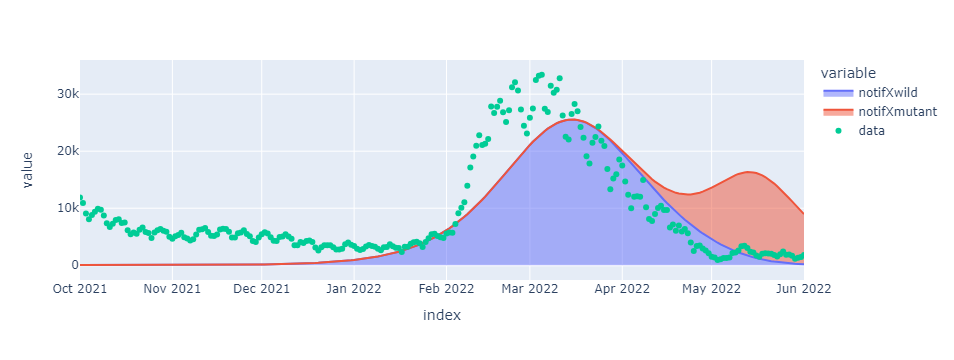

In [23]:
plot_start_date = datetime(2021, 10, 1)
plot = epi_model.get_derived_outputs_df()[[f'notifX{strat}' for strat in strain_strata]].plot.area()
plot.update_xaxes(range=(plot_start_date, analysis_end_date))
plot.add_trace(go.Scatter(x=cases_data.index, y=cases_data, mode='markers', name='data'))